In [1]:
!pip install transformers torch pandas numpy matplotlib scikit-learn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import os
import warnings
from tqdm.notebook import tqdm
from transformers import Trainer, TrainingArguments
from google.colab import drive
import copy
warnings.filterwarnings("ignore")

# Mount Google Drive
drive.mount('/content/drive')

# Check if GPU is available and print system info
!nvidia-smi
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Mounted at /content/drive
Sun May 11 10:24:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+---------------------

In [3]:
class FaaSRequestDataset(Dataset):
    def __init__(self, encodings, targets=None):
        self.encodings = encodings
        self.targets = targets

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.targets is not None:
            item['labels'] = self.targets[idx]
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

def prepare_time_series_data_from_df(df, context_length=24, prediction_length=1, test_size=0.2):
    # Ensure data is sorted by datetime
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime')

    # Extract target data
    data = df['target'].values

    # Scale target data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.reshape(-1, 1)).flatten()

    # Create sliding windows
    examples = []
    targets = []
    time_features_list = []

    # Use tqdm for progress visualization during window creation
    for i in tqdm(range(len(scaled_data) - context_length - prediction_length + 1),
                 desc="Creating sliding windows"):
        examples.append(scaled_data[i:i + context_length])
        targets.append(scaled_data[i + context_length:i + context_length + prediction_length])

        # Extract time features for this window
        time_feature_window = np.zeros((context_length, 2))  # For hour and day_of_week

        for j in range(context_length):
            idx = i + j
            if idx < len(df):
                # Normalize hour (0-23) and day_of_week (0-6)
                time_feature_window[j, 0] = df.iloc[idx]['hour'] / 23.0
                time_feature_window[j, 1] = df.iloc[idx]['day_of_week'] / 6.0

        time_features_list.append(time_feature_window)

    examples = np.array(examples)
    targets = np.array(targets)
    time_features = np.array(time_features_list)

    # Split into train and test
    train_size = int(len(examples) * (1 - test_size))

    X_train = examples[:train_size]
    y_train = targets[:train_size]
    time_features_train = time_features[:train_size]

    X_test = examples[train_size:]
    y_test = targets[train_size:]
    time_features_test = time_features[train_size:]

    print(f"Created {len(examples)} sliding windows")
    print(f"Training set: {len(X_train)} examples")
    print(f"Test set: {len(X_test)} examples")

    # Format data for the transformer
    train_encodings = {
        'input_ids': torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1),
        'time_features': torch.tensor(time_features_train, dtype=torch.float32)
    }

    test_encodings = {
        'input_ids': torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1),
        'time_features': torch.tensor(time_features_test, dtype=torch.float32)
    }

    train_targets = torch.tensor(y_train, dtype=torch.float32)
    test_targets = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = FaaSRequestDataset(train_encodings, train_targets)
    test_dataset = FaaSRequestDataset(test_encodings, test_targets)

    return train_dataset, test_dataset, scaler

In [4]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        return x + self.pe[:, :x.size(1)]

class TimeSeriesTransformer(torch.nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, output_dim, dropout=0.1):
        super().__init__()
        self.d_model = d_model

        # Input projection from input_dim to d_model
        self.input_projection = torch.nn.Linear(input_dim, d_model)

        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model)

        # Transformer encoder
        encoder_layer = torch.nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Output projection
        self.output_projection = torch.nn.Linear(d_model, output_dim)

    def forward(self, input_ids, time_features=None, attention_mask=None, labels=None):
        # Combine input values with time features if provided
        if time_features is not None:
            x = torch.cat([input_ids, time_features], dim=2)
        else:
            x = input_ids

        # Project to d_model
        x = self.input_projection(x)

        # Add positional encoding
        x = self.positional_encoding(x)

        # Apply transformer encoder
        if attention_mask is not None:
            x = self.transformer_encoder(x, src_key_padding_mask=attention_mask)
        else:
            x = self.transformer_encoder(x)

        # Use the last time step for prediction
        #x = x[:, -1, :]

        # Uses the mean of all steps in the sequence for prediction. Sequence pooling
        x = torch.mean(x, dim=1)

        # Project to output dimension
        prediction = self.output_projection(x)

        # Calculate loss if labels are provided
        loss = None
        if labels is not None:
            loss_fct = torch.nn.MSELoss()
            loss = loss_fct(prediction, labels)

        return {"loss": loss, "prediction": prediction} if loss is not None else {"prediction": prediction}

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.flatten()
    labels = labels.flatten()

    return {
        "mse": mean_squared_error(labels, predictions),
        "rmse": np.sqrt(mean_squared_error(labels, predictions)),
        "mae": mean_absolute_error(labels, predictions)
    }

In [5]:
def load_data_from_path(file_path):
    print(f"Loading data from: {file_path}")

    if not os.path.exists(file_path):
        raise ValueError(f"File not found: {file_path}")

    try:
        # First, check if there's an unnamed first column
        df_peek = pd.read_csv(file_path, nrows=5)
        column_names = list(df_peek.columns)

        # Print the first few rows and column names for debugging
        print("First 5 rows of data:")
        print(df_peek.head())
        print("\nColumn names in the file:")
        print(column_names)

        # Load the full dataframe
        # If the first column is unnamed, rename it to 'datetime'
        if 'Unnamed: 0' in column_names or '' in column_names:
            print("Detected unnamed first column. Renaming to 'datetime'")

            # Read with index_col=False to ensure we get all columns
            df = pd.read_csv(file_path, index_col=False)

            # Rename the unnamed column
            if 'Unnamed: 0' in df.columns:
                df = df.rename(columns={'Unnamed: 0': 'datetime'})
            elif '' in df.columns:
                df = df.rename(columns={'': 'datetime'})
            # For completely empty column name (no space)
            elif df.columns[0].strip() == '':
                new_cols = df.columns.tolist()
                new_cols[0] = 'datetime'
                df.columns = new_cols
        else:
            # Normal loading if all columns are named
            df = pd.read_csv(file_path)

            # If 'datetime' column is missing but there might be a date/time column with a different name
            if 'datetime' not in df.columns:
                # Look for any column that might contain datetime strings
                for col in df.columns:
                    # Try to parse the first value as datetime
                    try:
                        if isinstance(df[col].iloc[0], str) and '202' in df[col].iloc[0]:  # Quick check for datetime-like string
                            print(f"Column '{col}' appears to contain datetime values. Renaming to 'datetime'")
                            df = df.rename(columns={col: 'datetime'})
                            break
                    except:
                        continue

        # Verify required columns exist
        required_columns = ['target', 'hour', 'day_of_week']
        missing_columns = [col for col in required_columns if col not in df.columns]

        if 'datetime' not in df.columns:
            missing_columns.append('datetime')

        if missing_columns:
            print(f"Missing required columns: {missing_columns}")
            print("Available columns:", df.columns.tolist())
            raise ValueError(f"Required columns missing: {missing_columns}")

        print(f"Successfully loaded data with {len(df)} rows")
        print(f"Column dtypes:")
        print(df.dtypes)

        # Convert datetime to proper format if it's not already
        try:
            df['datetime'] = pd.to_datetime(df['datetime'])
            print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()}")
        except:
            print("Warning: Could not convert 'datetime' column to datetime format")
            print("First few values of datetime column:", df['datetime'].head().tolist())

        return df

    except Exception as e:
        print(f"Error details: {str(e)}")
        raise ValueError(f"Error loading file: {e}")

In [6]:
def predict_faas_requests(df, context_length=24, prediction_length=1, num_train_epochs=10):

    # Prepare datasets
    print(f"Preparing data with context_length={context_length}, prediction_length={prediction_length}")
    train_dataset, test_dataset, scaler = prepare_time_series_data_from_df(
        df, context_length, prediction_length, test_size=0.2
    )

# Initialize model
    # Calculate input dimension (target + time features)
    input_dim = 1 + 2  # 1 for target value, 2 for time features (hour, day_of_week)

    # Model parameters
    d_model = 64
    nhead = 4
    num_layers = 3
    dim_feedforward = 128
    output_dim = prediction_length
    dropout = 0.1

    print("Initializing custom transformer model")
    model = TimeSeriesTransformer(
        input_dim=input_dim,
        d_model=d_model,
        nhead=nhead,
        num_layers=num_layers,
        dim_feedforward=dim_feedforward,
        output_dim=output_dim,
        dropout=dropout
    ).to(device)

    print(f"Model initialized with {sum(p.numel() for p in model.parameters()):,} parameters")

    # Get dataloaders
    train_batch_size = 32
    eval_batch_size = 64
    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    eval_dataloader = DataLoader(test_dataset, batch_size=eval_batch_size)

    # Define optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

    # Early stopping setup
    best_rmse = float('inf')
    patience = 5
    patience_counter = 0
    best_model_state = None

    # Training loop
    print(f"Starting training for {num_train_epochs} epochs - this may take several minutes")

    for epoch in range(num_train_epochs):
        model.train()
        train_loss = 0.0

        # Training
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_train_epochs}")
        for batch in progress_bar:
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass
            outputs = model(
                input_ids=batch['input_ids'],
                time_features=batch['time_features'],
                labels=batch['labels']
            )

            loss = outputs['loss']
            train_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

        avg_train_loss = train_loss / len(train_dataloader)

        # Evaluation
        model.eval()
        eval_loss = 0.0
        eval_predictions = []
        eval_labels = []

        with torch.no_grad():
            for batch in tqdm(eval_dataloader, desc="Evaluating"):
                batch = {k: v.to(device) for k, v in batch.items()}

                outputs = model(
                    input_ids=batch['input_ids'],
                    time_features=batch['time_features'],
                    labels=batch['labels']
                )

                loss = outputs['loss']
                eval_loss += loss.item()

                eval_predictions.append(outputs['prediction'].cpu().numpy())
                eval_labels.append(batch['labels'].cpu().numpy())

        avg_eval_loss = eval_loss / len(eval_dataloader)

        # Calculate metrics
        eval_predictions = np.vstack(eval_predictions)
        eval_labels = np.vstack(eval_labels)

        mse = mean_squared_error(eval_labels, eval_predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(eval_labels, eval_predictions)

        # Calculate additional metrics - MAPE and R2
        mape = mean_absolute_percentage_error(eval_labels, eval_predictions)
        r2 = r2_score(eval_labels, eval_predictions)

        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Eval Loss: {avg_eval_loss:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%, R²: {r2:.4f}")

        # Early stopping check
        if rmse < best_rmse:
            best_rmse = rmse
            patience_counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), 'best_model.pt')
            print(f"  New best model saved with RMSE: {best_rmse:.4f}")
        else:
            patience_counter += 1
            print(f"  No improvement in RMSE for {patience_counter}/{patience} epochs")

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    # Load best model at the end of training
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with RMSE: {best_rmse:.4f}")

    # Final evaluation on the full test set
    print("Generating predictions on test set")
    predictions = []
    actuals = []

    model.eval()
    with torch.no_grad():
        for batch in tqdm(eval_dataloader, desc="Predicting"):
            # Move batch to the same device as the model
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(
                input_ids=batch['input_ids'],
                time_features=batch['time_features']
            )
            predictions.append(outputs['prediction'].cpu().numpy())
            actuals.append(batch['labels'].cpu().numpy())

    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)

    # Inverse transform to get original scale
    predictions_rescaled = scaler.inverse_transform(predictions)
    actuals_rescaled = scaler.inverse_transform(actuals)

    # Calculate metrics on original scale
    rmse = np.sqrt(mean_squared_error(actuals_rescaled, predictions_rescaled))
    mae = mean_absolute_error(actuals_rescaled, predictions_rescaled)
    mape = mean_absolute_percentage_error(actuals_rescaled, predictions_rescaled)


    print(f"Test RMSE (original scale): {rmse:.4f}")
    print(f"Test MAE (original scale): {mae:.4f}")
    print(f"Test MAPE: {mape:.4f}")


    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(actuals_rescaled.flatten(), label='Actual')
    plt.plot(predictions_rescaled.flatten(), label='Predicted')
    plt.title('FaaS Function Request Prediction')
    plt.xlabel('Time')
    plt.ylabel('Number of Requests')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Create and plot error distribution
    errors = actuals_rescaled.flatten() - predictions_rescaled.flatten()
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=30)
    plt.title('Prediction Error Distribution')
    plt.xlabel('Error (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Save model
    model_save_path = "/content/drive/MyDrive/Colab Notebooks/models/transformer_model.pt"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")
    save_path = "/content/drive/MyDrive/Colab Notebooks/results/transformer_test_results.csv"
    predictions_df = pd.DataFrame({'predictions': predictions_rescaled.flatten()})
    predictions_df.to_csv(save_path, index=False)

    return model, scaler


In [7]:
def evaluate_model_on_synthetic_data(model, df_synthetic, device=device, context_length=24, prediction_length=1):

    class FaaSRequestDataset(Dataset):
        def __init__(self, encodings, targets=None):
            self.encodings = encodings
            self.targets = targets

        def __getitem__(self, idx):
            item = {key: val[idx] for key, val in self.encodings.items()}
            if self.targets is not None:
                item['labels'] = self.targets[idx]
            return item

        def __len__(self):
            return len(self.encodings['input_ids'])

    def prepare_full_dataset(df):
        df['datetime'] = pd.to_datetime(df['datetime'])
        df = df.sort_values('datetime')

        data = df['target'].values
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(data.reshape(-1, 1)).flatten()

        examples, targets, time_features_list = [], [], []
        for i in range(len(scaled_data) - context_length - prediction_length + 1):
            examples.append(scaled_data[i:i + context_length])
            targets.append(scaled_data[i + context_length:i + context_length + prediction_length])
            tf_window = np.zeros((context_length, 2))
            for j in range(context_length):
                idx = i + j
                tf_window[j, 0] = df.iloc[idx]['hour'] / 23.0
                tf_window[j, 1] = df.iloc[idx]['day_of_week'] / 6.0
            time_features_list.append(tf_window)

        encodings = {
            'input_ids': torch.tensor(examples, dtype=torch.float32).unsqueeze(-1),
            'time_features': torch.tensor(time_features_list, dtype=torch.float32)
        }
        targets = torch.tensor(targets, dtype=torch.float32)

        dataset = FaaSRequestDataset(encodings, targets)
        return dataset, scaler

    # Prepare dataset
    dataset, scaler = prepare_full_dataset(df_synthetic)
    loader = DataLoader(dataset, batch_size=32)

    # Run inference
    model.to(device)
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            time_features = batch['time_features'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, time_features=time_features)
            preds = outputs['prediction']

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Flatten and inverse scale
    all_preds = np.concatenate(all_preds).flatten()
    all_labels = np.concatenate(all_labels).flatten()
    all_preds = scaler.inverse_transform(all_preds.reshape(-1, 1)).flatten()
    all_labels = scaler.inverse_transform(all_labels.reshape(-1, 1)).flatten()

    # Metrics
    mae = mean_absolute_error(all_labels, all_preds)
    rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
    mape = mean_absolute_percentage_error(all_labels, all_preds)
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}")

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(all_labels, label='Actual')
    plt.plot(all_preds, label='Predicted')
    plt.title("Model Prediction vs Actual (Synthetic Data)")
    plt.xlabel("Date")
    plt.ylabel("Number of requests")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    save_path = "/content/drive/MyDrive/Colab Notebooks/results/transformer_synthetic_results.csv"
    predictions_df = pd.DataFrame({'predictions': all_preds})
    predictions_df.to_csv(save_path, index=False)


Loading data from: /content/drive/MyDrive/Colab Notebooks/model_dataset_with_datetime.csv
Loading data from: /content/drive/MyDrive/Colab Notebooks/model_dataset_with_datetime.csv
First 5 rows of data:
            Unnamed: 0        target  hour  day_of_week
0  2025-02-22 00:00:00  22194.583333     0            5
1  2025-02-22 01:00:00  20487.250000     1            5
2  2025-02-22 02:00:00  20038.716667     2            5
3  2025-02-22 03:00:00  21519.316667     3            5
4  2025-02-22 04:00:00  18344.950000     4            5

Column names in the file:
['Unnamed: 0', 'target', 'hour', 'day_of_week']
Detected unnamed first column. Renaming to 'datetime'
Successfully loaded data with 2136 rows
Column dtypes:
datetime        object
target         float64
hour             int64
day_of_week      int64
dtype: object
Date range: 2025-02-22 00:00:00 to 2025-05-21 23:00:00

Training the model with the following parameters:
- Context length: 24 hours
- Prediction length: 1 hour(s)
- Traini

Creating sliding windows:   0%|          | 0/2112 [00:00<?, ?it/s]

Created 2112 sliding windows
Training set: 1689 examples
Test set: 423 examples
Initializing custom transformer model
Model initialized with 100,737 parameters
Starting training for 50 epochs - this may take several minutes


Epoch 1/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.0317, Eval Loss: 0.0226, RMSE: 0.1524, MAE: 0.1196, MAPE: 0.41%, R²: 0.0401
  New best model saved with RMSE: 0.1524


Epoch 2/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.0127, Eval Loss: 0.0165, RMSE: 0.1310, MAE: 0.0943, MAPE: 0.38%, R²: 0.2903
  New best model saved with RMSE: 0.1310


Epoch 3/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.0099, Eval Loss: 0.0127, RMSE: 0.1151, MAE: 0.0790, MAPE: 0.35%, R²: 0.4526
  New best model saved with RMSE: 0.1151


Epoch 4/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.0083, Eval Loss: 0.0108, RMSE: 0.1065, MAE: 0.0705, MAPE: 0.33%, R²: 0.5316
  New best model saved with RMSE: 0.1065


Epoch 5/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.0077, Eval Loss: 0.0103, RMSE: 0.1038, MAE: 0.0658, MAPE: 0.33%, R²: 0.5548
  New best model saved with RMSE: 0.1038


Epoch 6/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.0071, Eval Loss: 0.0097, RMSE: 0.1003, MAE: 0.0637, MAPE: 0.33%, R²: 0.5842
  New best model saved with RMSE: 0.1003


Epoch 7/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.0067, Eval Loss: 0.0096, RMSE: 0.0999, MAE: 0.0632, MAPE: 0.33%, R²: 0.5879
  New best model saved with RMSE: 0.0999


Epoch 8/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.0068, Eval Loss: 0.0083, RMSE: 0.0931, MAE: 0.0606, MAPE: 0.30%, R²: 0.6416
  New best model saved with RMSE: 0.0931


Epoch 9/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.0061, Eval Loss: 0.0100, RMSE: 0.1012, MAE: 0.0686, MAPE: 0.34%, R²: 0.5766
  No improvement in RMSE for 1/5 epochs


Epoch 10/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.0059, Eval Loss: 0.0070, RMSE: 0.0856, MAE: 0.0539, MAPE: 0.30%, R²: 0.6968
  New best model saved with RMSE: 0.0856


Epoch 11/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11: Train Loss: 0.0051, Eval Loss: 0.0073, RMSE: 0.0866, MAE: 0.0566, MAPE: 0.30%, R²: 0.6903
  No improvement in RMSE for 1/5 epochs


Epoch 12/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12: Train Loss: 0.0051, Eval Loss: 0.0064, RMSE: 0.0817, MAE: 0.0515, MAPE: 0.29%, R²: 0.7239
  New best model saved with RMSE: 0.0817


Epoch 13/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13: Train Loss: 0.0049, Eval Loss: 0.0057, RMSE: 0.0773, MAE: 0.0460, MAPE: 0.28%, R²: 0.7530
  New best model saved with RMSE: 0.0773


Epoch 14/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14: Train Loss: 0.0046, Eval Loss: 0.0080, RMSE: 0.0903, MAE: 0.0629, MAPE: 0.32%, R²: 0.6634
  No improvement in RMSE for 1/5 epochs


Epoch 15/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15: Train Loss: 0.0046, Eval Loss: 0.0072, RMSE: 0.0863, MAE: 0.0579, MAPE: 0.31%, R²: 0.6924
  No improvement in RMSE for 2/5 epochs


Epoch 16/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16: Train Loss: 0.0044, Eval Loss: 0.0061, RMSE: 0.0793, MAE: 0.0509, MAPE: 0.29%, R²: 0.7401
  No improvement in RMSE for 3/5 epochs


Epoch 17/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17: Train Loss: 0.0040, Eval Loss: 0.0101, RMSE: 0.1013, MAE: 0.0778, MAPE: 0.34%, R²: 0.5757
  No improvement in RMSE for 4/5 epochs


Epoch 18/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18: Train Loss: 0.0045, Eval Loss: 0.0048, RMSE: 0.0705, MAE: 0.0421, MAPE: 0.26%, R²: 0.7944
  New best model saved with RMSE: 0.0705


Epoch 19/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19: Train Loss: 0.0037, Eval Loss: 0.0058, RMSE: 0.0771, MAE: 0.0499, MAPE: 0.28%, R²: 0.7543
  No improvement in RMSE for 1/5 epochs


Epoch 20/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20: Train Loss: 0.0039, Eval Loss: 0.0055, RMSE: 0.0755, MAE: 0.0483, MAPE: 0.28%, R²: 0.7644
  No improvement in RMSE for 2/5 epochs


Epoch 21/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 21: Train Loss: 0.0036, Eval Loss: 0.0043, RMSE: 0.0670, MAE: 0.0384, MAPE: 0.24%, R²: 0.8146
  New best model saved with RMSE: 0.0670


Epoch 22/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 22: Train Loss: 0.0036, Eval Loss: 0.0044, RMSE: 0.0679, MAE: 0.0384, MAPE: 0.25%, R²: 0.8094
  No improvement in RMSE for 1/5 epochs


Epoch 23/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 23: Train Loss: 0.0037, Eval Loss: 0.0066, RMSE: 0.0823, MAE: 0.0567, MAPE: 0.29%, R²: 0.7198
  No improvement in RMSE for 2/5 epochs


Epoch 24/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 24: Train Loss: 0.0034, Eval Loss: 0.0041, RMSE: 0.0654, MAE: 0.0374, MAPE: 0.24%, R²: 0.8233
  New best model saved with RMSE: 0.0654


Epoch 25/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 25: Train Loss: 0.0035, Eval Loss: 0.0042, RMSE: 0.0662, MAE: 0.0394, MAPE: 0.24%, R²: 0.8188
  No improvement in RMSE for 1/5 epochs


Epoch 26/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 26: Train Loss: 0.0034, Eval Loss: 0.0043, RMSE: 0.0667, MAE: 0.0367, MAPE: 0.25%, R²: 0.8161
  No improvement in RMSE for 2/5 epochs


Epoch 27/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 27: Train Loss: 0.0033, Eval Loss: 0.0040, RMSE: 0.0643, MAE: 0.0362, MAPE: 0.24%, R²: 0.8290
  New best model saved with RMSE: 0.0643


Epoch 28/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 28: Train Loss: 0.0032, Eval Loss: 0.0043, RMSE: 0.0665, MAE: 0.0377, MAPE: 0.25%, R²: 0.8175
  No improvement in RMSE for 1/5 epochs


Epoch 29/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 29: Train Loss: 0.0033, Eval Loss: 0.0049, RMSE: 0.0707, MAE: 0.0448, MAPE: 0.26%, R²: 0.7935
  No improvement in RMSE for 2/5 epochs


Epoch 30/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 30: Train Loss: 0.0031, Eval Loss: 0.0043, RMSE: 0.0669, MAE: 0.0393, MAPE: 0.25%, R²: 0.8148
  No improvement in RMSE for 3/5 epochs


Epoch 31/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 31: Train Loss: 0.0029, Eval Loss: 0.0048, RMSE: 0.0706, MAE: 0.0441, MAPE: 0.26%, R²: 0.7940
  No improvement in RMSE for 4/5 epochs


Epoch 32/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 32: Train Loss: 0.0030, Eval Loss: 0.0038, RMSE: 0.0631, MAE: 0.0346, MAPE: 0.24%, R²: 0.8354
  New best model saved with RMSE: 0.0631


Epoch 33/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 33: Train Loss: 0.0029, Eval Loss: 0.0038, RMSE: 0.0626, MAE: 0.0339, MAPE: 0.23%, R²: 0.8378
  New best model saved with RMSE: 0.0626


Epoch 34/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 34: Train Loss: 0.0028, Eval Loss: 0.0042, RMSE: 0.0661, MAE: 0.0376, MAPE: 0.25%, R²: 0.8193
  No improvement in RMSE for 1/5 epochs


Epoch 35/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 35: Train Loss: 0.0028, Eval Loss: 0.0037, RMSE: 0.0618, MAE: 0.0334, MAPE: 0.23%, R²: 0.8420
  New best model saved with RMSE: 0.0618


Epoch 36/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 36: Train Loss: 0.0028, Eval Loss: 0.0036, RMSE: 0.0613, MAE: 0.0328, MAPE: 0.23%, R²: 0.8447
  New best model saved with RMSE: 0.0613


Epoch 37/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 37: Train Loss: 0.0027, Eval Loss: 0.0044, RMSE: 0.0671, MAE: 0.0409, MAPE: 0.25%, R²: 0.8139
  No improvement in RMSE for 1/5 epochs


Epoch 38/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 38: Train Loss: 0.0027, Eval Loss: 0.0046, RMSE: 0.0691, MAE: 0.0440, MAPE: 0.26%, R²: 0.8029
  No improvement in RMSE for 2/5 epochs


Epoch 39/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 39: Train Loss: 0.0028, Eval Loss: 0.0036, RMSE: 0.0613, MAE: 0.0334, MAPE: 0.23%, R²: 0.8446
  No improvement in RMSE for 3/5 epochs


Epoch 40/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 40: Train Loss: 0.0030, Eval Loss: 0.0049, RMSE: 0.0708, MAE: 0.0467, MAPE: 0.26%, R²: 0.7930
  No improvement in RMSE for 4/5 epochs


Epoch 41/50:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 41: Train Loss: 0.0027, Eval Loss: 0.0040, RMSE: 0.0640, MAE: 0.0366, MAPE: 0.24%, R²: 0.8305
  No improvement in RMSE for 5/5 epochs
Early stopping triggered after 41 epochs
Loaded best model with RMSE: 0.0613
Generating predictions on test set


Predicting:   0%|          | 0/7 [00:00<?, ?it/s]

Test RMSE (original scale): 3646.9748
Test MAE (original scale): 1954.4181
Test MAPE: 0.0837


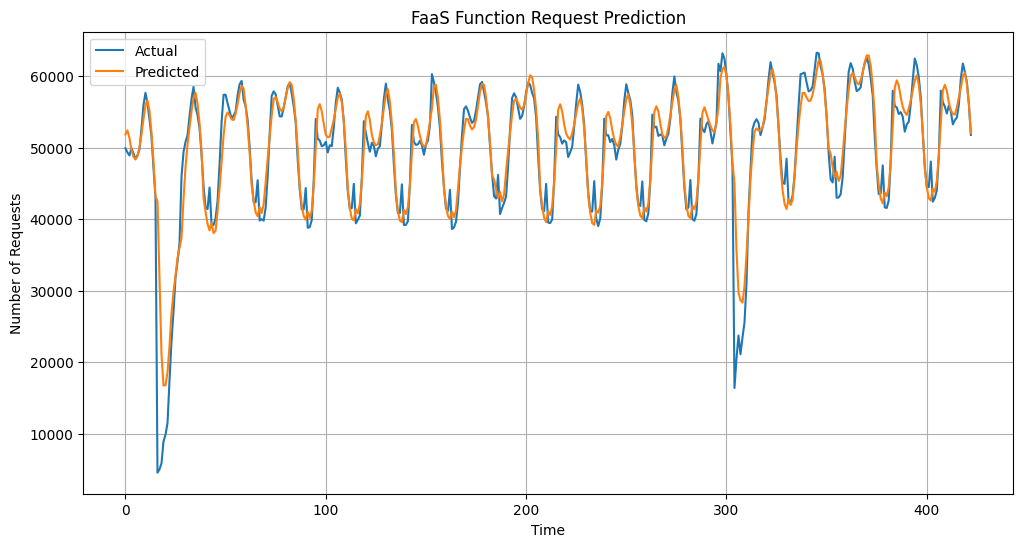

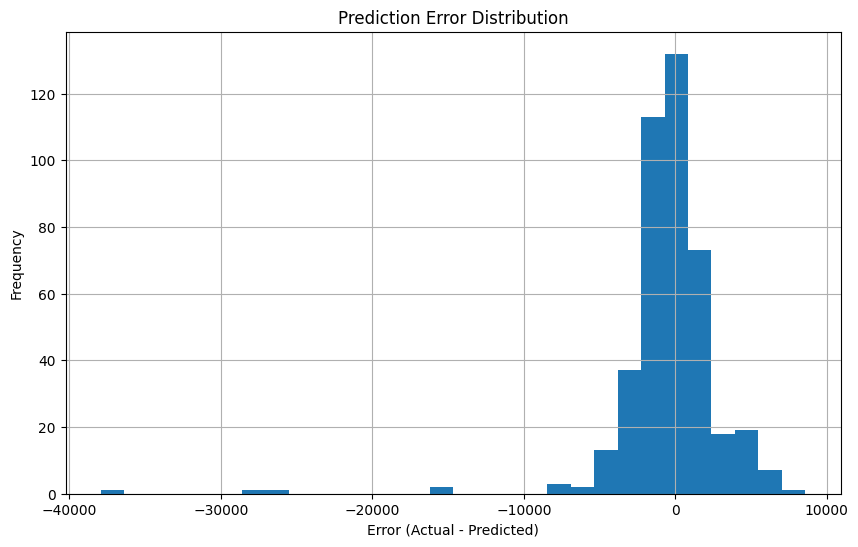

Model saved to /content/drive/MyDrive/Colab Notebooks/models/transformer_model.pt


In [8]:
# @title Set Model Parameters { run: "auto" }
file_path = "/content/drive/MyDrive/Colab Notebooks/model_dataset_with_datetime.csv"  # @param {type:"string"}
context_length = 24  # @param {type:"slider", min:1, max:168, step:1}
prediction_length = 1  # @param {type:"slider", min:1, max:24, step:1}
training_epochs = 50  # @param {type:"slider", min:1, max:50, step:1}


print(f"Loading data from: {file_path}")
df = load_data_from_path(file_path)

print("\nTraining the model with the following parameters:")
print(f"- Context length: {context_length} hours")
print(f"- Prediction length: {prediction_length} hour(s)")
print(f"- Training epochs: {training_epochs}")

model, scaler = predict_faas_requests(
    df=df,
    context_length=context_length,
    prediction_length=prediction_length,
    num_train_epochs=training_epochs
)



MAE: 47.4690
RMSE: 63.9178
MAPE: 0.27


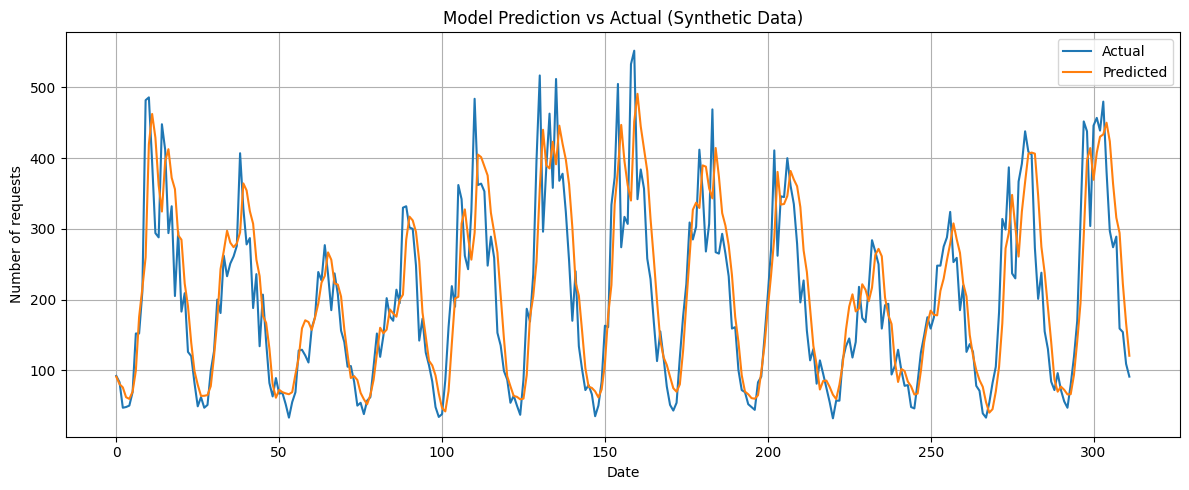

In [9]:
df_csv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/synthetic_dataset.csv')
evaluate_model_on_synthetic_data(model,df_csv,device=device)